# Homework 3 - Deep Learning
***Author: Christopher Wagner***

In [1]:
# Import libraries...
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import feature_column

from keras import backend as K
from keras.layers import Layer
from keras.initializers import Constant

### Multi Class Mappings

In [2]:
# Map the labels to 8 classes
label_class_map = {
    "DDoS-RSTFINFlood": "DDoS",
    "DDoS-PSHACK_Flood": "DDoS",
    "DDoS-SYN_Flood": "DDoS",
    "DDoS-UDP_Flood": "DDoS",
    "DDoS-TCP_Flood": "DDoS",
    "DDoS-ICMP_Flood": "DDoS",
    "DDoS-SynonymousIP_Flood": "DDoS",
    "DDoS-ACK_Fragmentation": "DDoS",
    "DDoS-UDP_Fragmentation": "DDoS",
    "DDoS-ICMP_Fragmentation": "DDoS",
    "DDoS-SlowLoris": "DDoS",
    "DDoS-HTTP_Flood": "DDoS",
    
    "DoS-UDP_Flood": "DoS",
    "DoS-SYN_Flood": "DoS",
    "DoS-TCP_Flood": "DoS",
    "DoS-HTTP_Flood": "DoS",
    
    "Mirai-greeth_flood": "Mirai",
    "Mirai-greip_flood": "Mirai",
    "Mirai-udpplain": "Mirai",
    
    "Recon-PingSweep": "Recon",
    "Recon-OSScan": "Recon",
    "Recon-PortScan": "Recon",
    "VulnerabilityScan": "Recon",
    "Recon-HostDiscovery": "Recon",
    
    "DNS_Spoofing": "Spoofing",
    "MITM-ArpSpoofing": "Spoofing",
    
    "BenignTraffic": "Benign",
    
    "BrowserHijacking": "Web",
    "Backdoor_Malware": "Web",
    "XSS": "Web",
    "Uploading_Attack": "Web",
    "SqlInjection": "Web",
    "CommandInjection": "Web",
    
    "DictionaryBruteForce": "BruteForce"   
}

# Map the labels to 8 classes
classes = ['Benign', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web', 'BruteForce']

def map_label_to_number(y: pd.Series):
    """Maps the labels to 8 numeric classes.

    Args:
        y (pd.Series): The current labels. 

    Returns:
        list: The new labels.
    """
    return [classes.index(label_class_map[label]) for label in y]

def map_number_to_class(y: pd.Series):
    """Maps the 8 numeric classes to their respective labels.

    Args:
        y (pd.Series): The current labels. 

    Returns:
        list: The new labels.
    """
    return [classes[label] for label in y]

### Import Dataset

In [18]:
# Using smaller dataset for testing purposes, has 1_048_575 rows
DATASET_FILE = "../datasets/IoT_Intrusion.csv"
df = pd.read_csv(DATASET_FILE)

# Rename columns
df.rename(columns={
    "Protocol Type": "Protocol_Type",
    "Tot sum": "Tot_sum",
    "Tot size": "Tot_size",
    "label": "target"
}, inplace=True)

df.shape

(1048575, 47)

In [19]:
# Define the features and target columns
X_columns = df.columns.to_list()[:-1]
y_column = 'target'

X = df[X_columns]
y = df[y_column]

# Map the target column to numerical values
y = map_label_to_number(y)
# print headers
print(df.columns)

Index(['flow_duration', 'Header_Length', 'Protocol_Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot_sum', 'Min', 'Max', 'AVG', 'Std', 'Tot_size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'target'],
      dtype='object')


In [20]:
data_counts = {
    "dataset": pd.Series(map_number_to_class(y)).value_counts().to_list(),
}
print(pd.DataFrame(data_counts, index=classes))

            dataset
Benign       763525
DDoS         181481
DoS           59233
Mirai         24476
Recon         11053
Spoofing       7945
Web             538
BruteForce      324


### Split the Dataset into Training and Test Sets

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

# Print the basic statistics of the training set
data_counts = {
    "train": pd.Series(map_number_to_class(y_train)).value_counts().to_list(),
    "test": pd.Series(map_number_to_class(y_test)).value_counts().to_list(),
    "validation": pd.Series(map_number_to_class(y_val)).value_counts().to_list(),
    "total": pd.Series(y).value_counts().to_list(),
}
print(pd.DataFrame(data_counts, index=classes))

             train    test  validation   total
Benign      611049  122060       30416  763525
DDoS        145059   29080        7342  181481
DoS          47272    9583        2378   59233
Mirai        19598    3892         986   24476
Recon         8850    1750         453   11053
Spoofing      6337    1277         331    7945
Web            439      77          22     538
BruteForce     256      53          15     324


### Pre-Process the Data

In [17]:
# Standardize the data
ss = StandardScaler(copy=True, with_mean=True, with_std=True)

# Fit the scaler on the training data
ss.fit(X_train)

# Transform the training, validation, and testing data
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Convert the data into dataframes
train_df = pd.DataFrame(X_train, columns=X_columns).assign(target=y_train)
val_df = pd.DataFrame(X_val, columns=X_columns).assign(target=y_val)
test_df = pd.DataFrame(X_test, columns=X_columns).assign(target=y_test)

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """Converts a dataframe to a dataset.

    Args:
        dataframe (DataFrame): The dataframe to convert. 
        shuffle (bool, optional): Enables whether the dataset should be shuffled. Defaults to True.
        batch_size (int, optional): Determines the batch size of the dataset. Defaults to 32.

    Returns:
        tf.data.Dataset: The converted dataset.
    """
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Convert the dataframes into datasets
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df, shuffle=False)
test_ds = df_to_dataset(test_df, shuffle=False)

# Convert the X columns into numeric feature columns
feature_columns = [feature_column.numeric_column(feature) for feature in X_columns]

MemoryError: Unable to allocate 12.8 GiB for an array with shape (46, 37349263) and data type float64

### Multi-Layer Perceptron (MLP) Model

Epoch 1/10
26215/26215 [==============================] - 53s 1ms/step - loss: 0.3893 - accuracy: 0.8381 - val_loss: 0.3621 - val_accuracy: 0.8495
Epoch 2/10
26215/26215 [==============================] - 57s 2ms/step - loss: 0.2387 - accuracy: 0.9314 - val_loss: 0.1427 - val_accuracy: 0.9820
Epoch 3/10
26215/26215 [==============================] - 55s 2ms/step - loss: 0.1403 - accuracy: 0.9799 - val_loss: 0.1225 - val_accuracy: 0.9836
Epoch 4/10
26215/26215 [==============================] - 52s 1ms/step - loss: 0.1253 - accuracy: 0.9820 - val_loss: 0.1151 - val_accuracy: 0.9851
Epoch 5/10
26215/26215 [==============================] - 53s 2ms/step - loss: 0.1207 - accuracy: 0.9821 - val_loss: 0.1231 - val_accuracy: 0.9825
Epoch 6/10
26215/26215 [==============================] - 53s 1ms/step - loss: 0.1174 - accuracy: 0.9825 - val_loss: 0.1084 - val_accuracy: 0.9847
Epoch 7/10
26215/26215 [==============================] - 52s 2ms/step - loss: 0.1148 - accuracy: 0.9827 - val_loss: 0

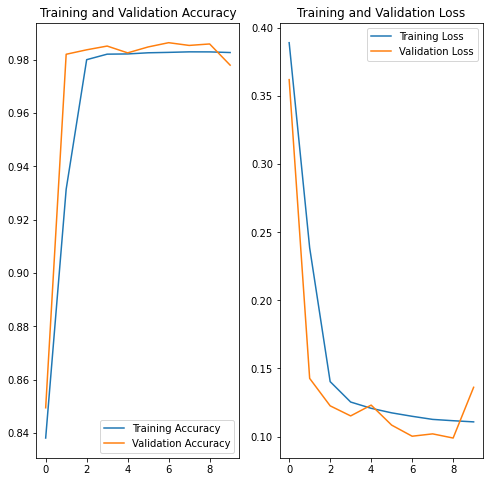

In [12]:
def build_mlp_model(feature_columns):
    """Builds the MLP model.

    Args:
        feature_columns (list): The feature columns.

    Returns:
        tf.keras.Sequential: The MLP model.
    """
    regularization = tf.keras.regularizers.l2(0.001)
    
    model = tf.keras.Sequential([
        # Define the input layer
        tf.keras.layers.DenseFeatures(feature_columns),
        
        # Define the hidden layers
        tf.keras.layers.Dense(47, activation='tanh', kernel_regularizer=regularization),
        tf.keras.layers.Dense(23, activation='tanh', kernel_regularizer=regularization),
        tf.keras.layers.Dense(12, activation='tanh', kernel_regularizer=regularization),
        tf.keras.layers.Dense(8, activation='tanh', kernel_regularizer=regularization),
        
        # Define the output layer
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

# Define an early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Build the model
model = build_mlp_model(feature_columns)

# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)

# Plot the training and validation accuracy
# to see if the model is overfitting
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
mlp_probabilities = model.predict(test_ds)

5243/5243 [==============================] - 6s 1ms/step


In [17]:
# Get the predicted class indices
predicted_classes = tf.argmax(mlp_probabilities, axis=1)

# Convert to numpy array for easier inspection
predicted_classes_mlp = predicted_classes.numpy()

# Calculate the metrics of the model
print(classification_report(y_test, predicted_classes_mlp, target_names=classes, zero_division=0, digits=4))

              precision    recall  f1-score   support

      Benign     0.7173    0.9375    0.8127      3907
        DDoS     0.9949    0.9907    0.9928    122244
         DoS     0.9990    0.9822    0.9905     28905
       Mirai     0.8931    0.9949    0.9413      9487
       Recon     0.7338    0.4759    0.5774      1309
    Spoofing     0.7786    0.4796    0.5936      1789
         Web     0.0000    0.0000    0.0000        76
  BruteForce     0.0000    0.0000    0.0000        55

    accuracy                         0.9780    167772
   macro avg     0.6396    0.6076    0.6135    167772
weighted avg     0.9782    0.9780    0.9770    167772



### Radias Basis Function Network (RBFN) Model

Epoch 1/10
26215/26215 [==============================] - 56s 2ms/step - loss: 0.4235 - accuracy: 0.8121 - val_loss: 0.3831 - val_accuracy: 0.8238
Epoch 2/10
26215/26215 [==============================] - 55s 2ms/step - loss: 0.3770 - accuracy: 0.8261 - val_loss: 0.3771 - val_accuracy: 0.8272
Epoch 3/10
26215/26215 [==============================] - 55s 2ms/step - loss: 0.3702 - accuracy: 0.8294 - val_loss: 0.3671 - val_accuracy: 0.8310
Epoch 4/10
26215/26215 [==============================] - 56s 2ms/step - loss: 0.3651 - accuracy: 0.8313 - val_loss: 0.3623 - val_accuracy: 0.8336
Epoch 5/10
26215/26215 [==============================] - 55s 2ms/step - loss: 0.3597 - accuracy: 0.8334 - val_loss: 0.3573 - val_accuracy: 0.8347
Epoch 6/10
26215/26215 [==============================] - 57s 2ms/step - loss: 0.3567 - accuracy: 0.8346 - val_loss: 0.3582 - val_accuracy: 0.8333
Epoch 7/10
26215/26215 [==============================] - 56s 2ms/step - loss: 0.3548 - accuracy: 0.8352 - val_loss: 0

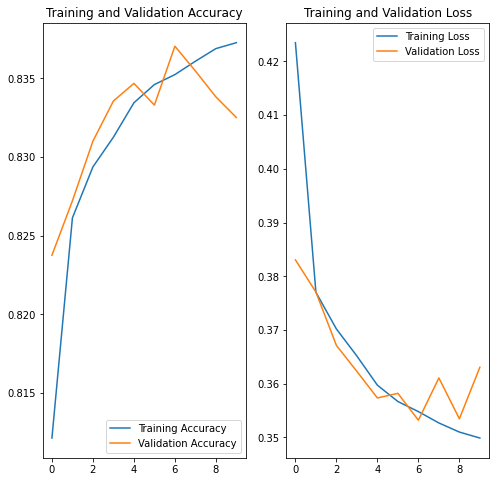

In [18]:
class RBFLayer(Layer):
    """Implements a radial basis function layer.

    Args:
        output_dim (int): Number of radial basis functions (RBFs) or neurons in the layer.
        betas (float or list of floats): Spread parameter(s) controlling the width of the RBFs.
            If a single float, it is applied to all RBFs. If a list, each element corresponds
            to the spread of a specific RBF.
        **kwargs: Additional keyword arguments for the base Layer class.
    """
    def __init__(self, output_dim, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
   
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Expand dimensions of centers to make it compatible with input
        C = K.expand_dims(self.centers)

        # Calculate the pairwise differences between each input and each center
        # by subtracting the transposed inputs from the expanded centers
        H = K.transpose(C - K.transpose(inputs))

        # Compute the squared Euclidean distances between inputs and centers
        squared_distances = K.sum(H**2, axis=1)

        # Apply the Gaussian function to the squared distances
        activation = K.exp(-self.betas * squared_distances)

        return activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

def build_rbfn_model(feature_columns):    
    model = tf.keras.Sequential([
        # Define the input layer
        tf.keras.layers.DenseFeatures(feature_columns),
        
        # Hidden layer with RBF activation function
        RBFLayer(28, .1),
        
        # Output layer
        tf.keras.layers.Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

    return model

# Define an early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Build the model
model = build_rbfn_model(feature_columns)

# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)

# Plot the training and validation accuracy
# to see if the model is overfitting
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
rbfn_probabilities = model.predict(test_ds)

5243/5243 [==============================] - 7s 1ms/step


In [20]:
# Get the predicted class indices
predicted_classes = tf.argmax(rbfn_probabilities, axis=1)

# Convert to numpy array for easier inspection
predicted_classes_rbfn = predicted_classes.numpy()

# Calculate the metrics of the model
print(classification_report(y_test, predicted_classes_rbfn, target_names=classes, zero_division=0, digits=4))

              precision    recall  f1-score   support

      Benign     0.5731    0.9995    0.7285      3907
        DDoS     0.8339    0.9923    0.9063    122244
         DoS     0.8787    0.1617    0.2731     28905
       Mirai     0.9987    0.9900    0.9943      9487
       Recon     0.7876    0.3117    0.4466      1309
    Spoofing     0.9405    0.1325    0.2322      1789
         Web     0.0000    0.0000    0.0000        76
  BruteForce     0.0000    0.0000    0.0000        55

    accuracy                         0.8340    167772
   macro avg     0.6266    0.4485    0.4476    167772
weighted avg     0.8450    0.8340    0.7865    167772

